In [ ]:
pip install --upgrade kmodes

In [ ]:
pip install --upgrade hdbscan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 41.9 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import hdbscan
from kmodes.kmodes import KModes

# Path to the Excel file
file_path = 'Specialization_Dataset.xlsx'

# Read the Excel file into a dictionary of DataFrames, where each sheet becomes a DataFrame
excel_data = pd.read_excel(file_path, sheet_name=None)

# Initialize an empty list to hold the DataFrames
dfs = []

# Iterate through the sheets in the Excel file
for sheet_name, sheet_data in excel_data.items():
    # Append each sheet's DataFrame to the list
    if sheet_name != "Combined":
      dfs.append(sheet_data)

# Concatenate all the DataFrames vertically (stack them on top of each other)
final_df = pd.concat(dfs, ignore_index=True)

# Display the final concatenated DataFrame
print(final_df)

     User_ID  Specialization Preference 1 Preference 2 Preference 3  \
0    DAT_001            Data            R            C          SQL   
1    DAT_002            Data            R          C++      VB .net   
2    DAT_003            Data          SQL  Java Script            R   
3    DAT_004            Data            R         Rust      VB .net   
4    DAT_005            Data       Python  Java Script           C#   
..       ...             ...          ...          ...          ...   
555  GAM_076  Game developer            C          C++         Java   
556  GAM_077  Game developer            C         Rust          VBA   
557  GAM_078  Game developer            C           C#            R   
558  GAM_079  Game developer         Rust      VB .net  Java Script   
559  GAM_080  Game developer            C           C#         Ruby   

    Years of experience Overall coding competency     General Hobbies 1  \
0          4 to 7 years                    Expert  Social & Exploration 

# K-Modes for Categorical Clustering

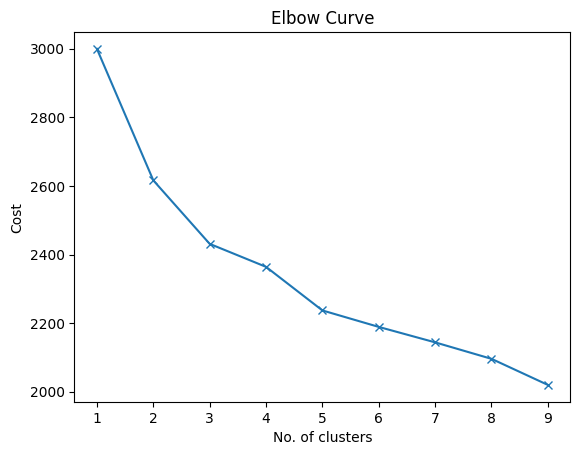

In [ ]:
cost = []
K = range(1,10)
for k in list(K):
    kmode = KModes(n_clusters=k, init = "random", n_init = 6, verbose=0)
    kmode.fit_predict(final_df.iloc[:,2:])
    cost.append(kmode.cost_)

plt.plot(K, cost, 'x-')
plt.xlabel('No. of clusters')
plt.ylabel('Cost')
plt.title('Elbow Curve')
plt.show()

Elbow found at 4 clusters.

In [ ]:
km = KModes(n_clusters=4, init='Huang', n_init=5, verbose=1)

# drop user ID and specialization columns (too obvious to group by them)
final_df["clusters"] = km.fit_predict(final_df.iloc[:,2:])

# Print the cluster centroids
print(km.cluster_centroids_)

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 1, iteration: 1/100, moves: 120, cost: 2322.0
Run 1, iteration: 2/100, moves: 15, cost: 2322.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 2, iteration: 1/100, moves: 171, cost: 2371.0
Run 2, iteration: 2/100, moves: 37, cost: 2371.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 3, iteration: 1/100, moves: 97, cost: 2421.0
Run 3, iteration: 2/100, moves: 0, cost: 2421.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 4, iteration: 1/100, moves: 21, cost: 2444.0
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run 5, iteration: 1/100, moves: 120, cost: 2367.0
Run 5, iteration: 2/100, moves: 32, cost: 2367.0
Best run was number 1
[['Python' 'VBA' 'C' '10+ years' 'Expert' 'Social & Exploration'
  'Creative Arts']
 ['Java' 'C++' 'golang' '4 to 7 years' 'Good' 'Gami

In [ ]:
final_df[final_df["clusters"] == 0].head()

,User_ID,Specialization,Preference 1,Preference 2,Preference 3,Years of experience,Overall coding competency,General Hobbies 1,General Hobbies 2,clusters
0,DAT_001,Data,R,C,SQL,4 to 7 years,Expert,Social & Exploration,Creative Arts,0
2,DAT_003,Data,SQL,Java Script,R,0 to 3 years,Good,Social & Exploration,Creative Arts,0
3,DAT_004,Data,R,Rust,VB .net,8 to 10 years,Expert,Social & Exploration,Gaming & Tech,0
4,DAT_005,Data,Python,Java Script,C#,0 to 3 years,Good,Social & Exploration,Physical Activities,0
8,DAT_009,Data,Python,Ruby,C,10+ years,Expert,Gaming & Tech,Social & Exploration,0


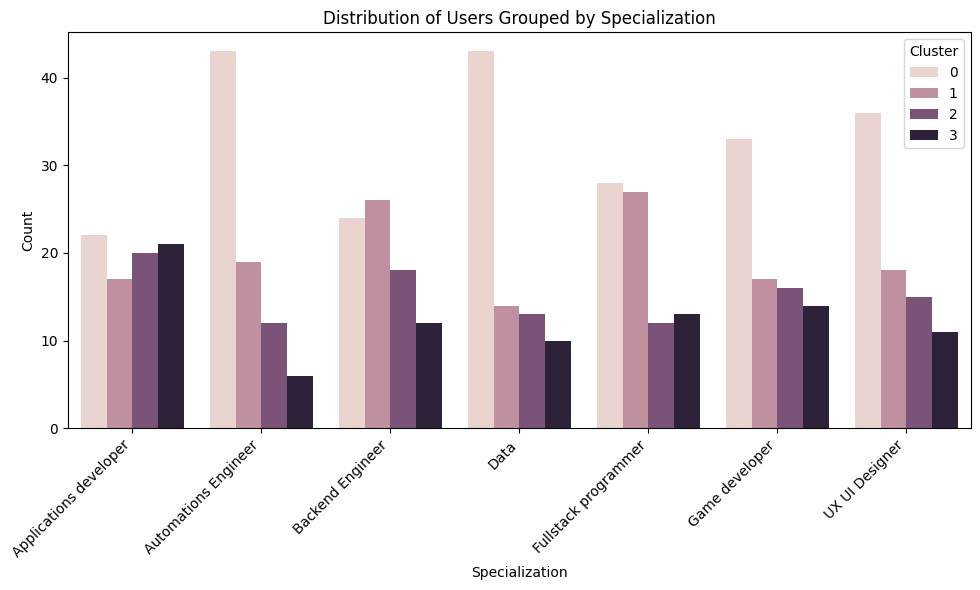

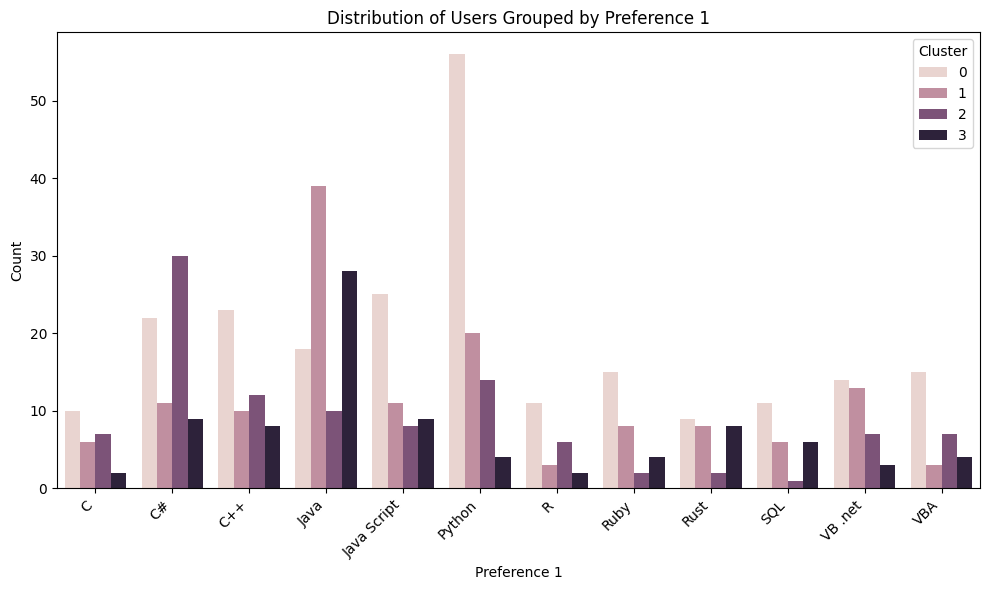

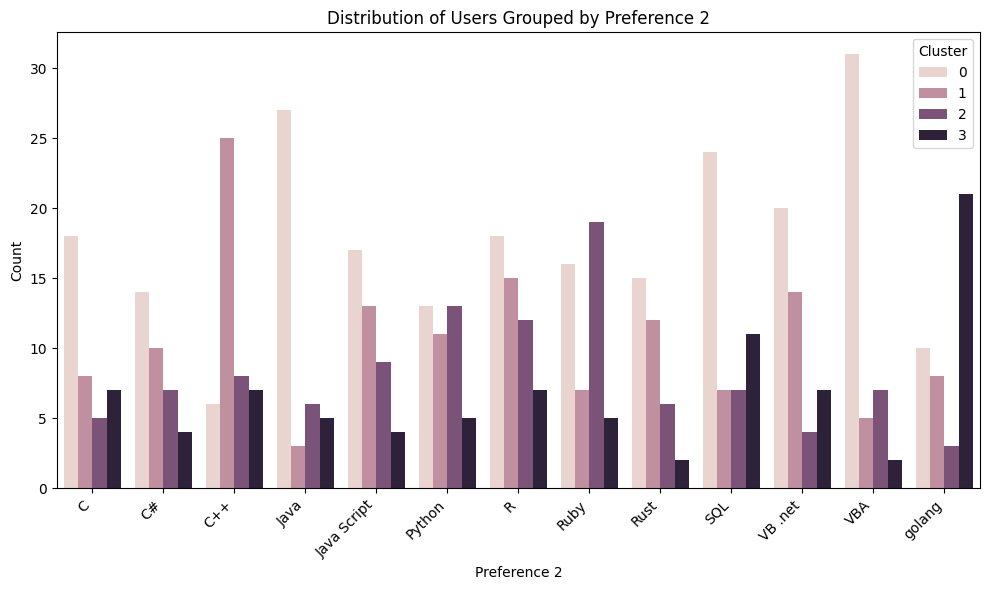

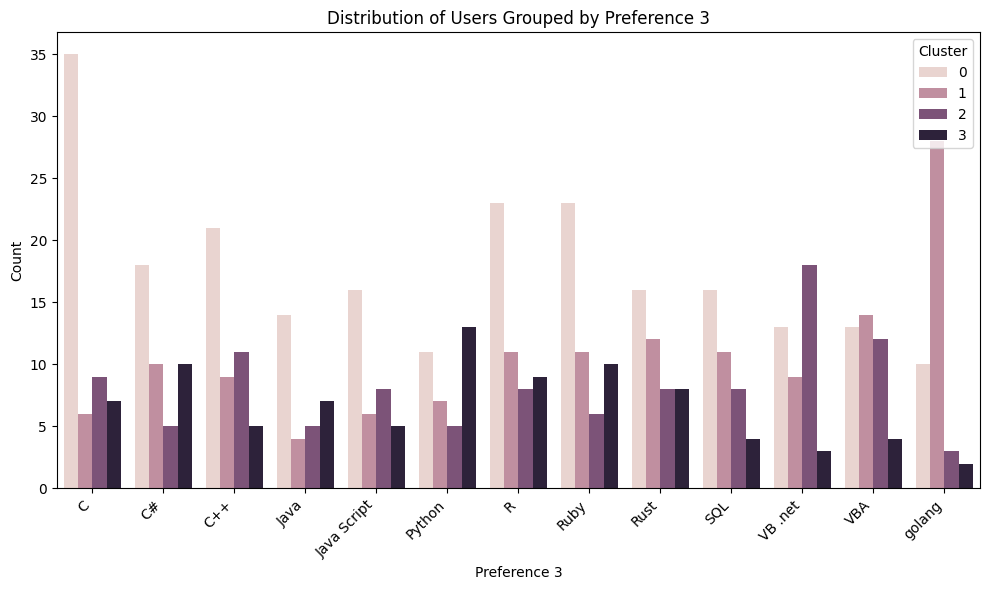

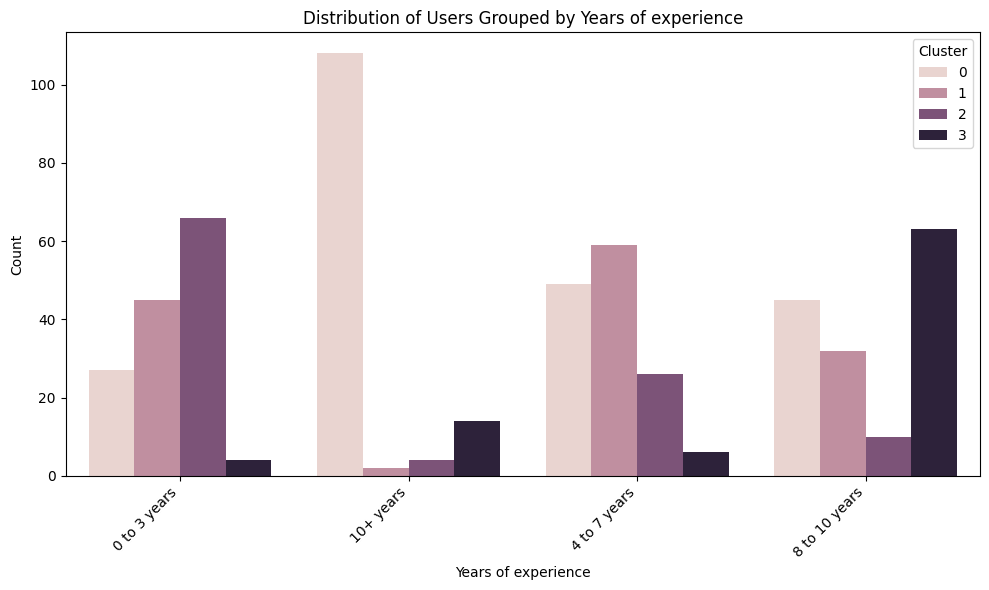

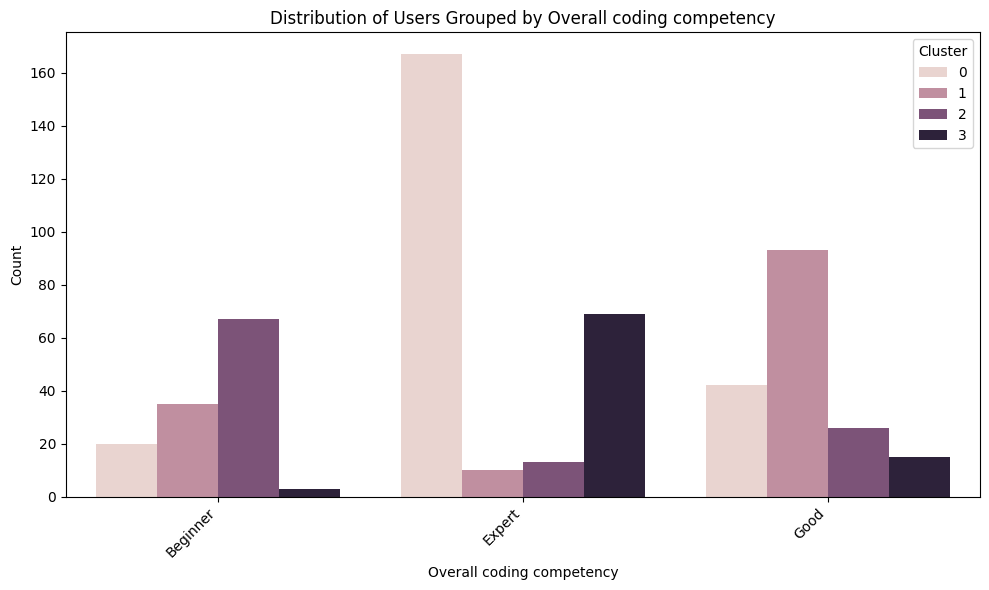

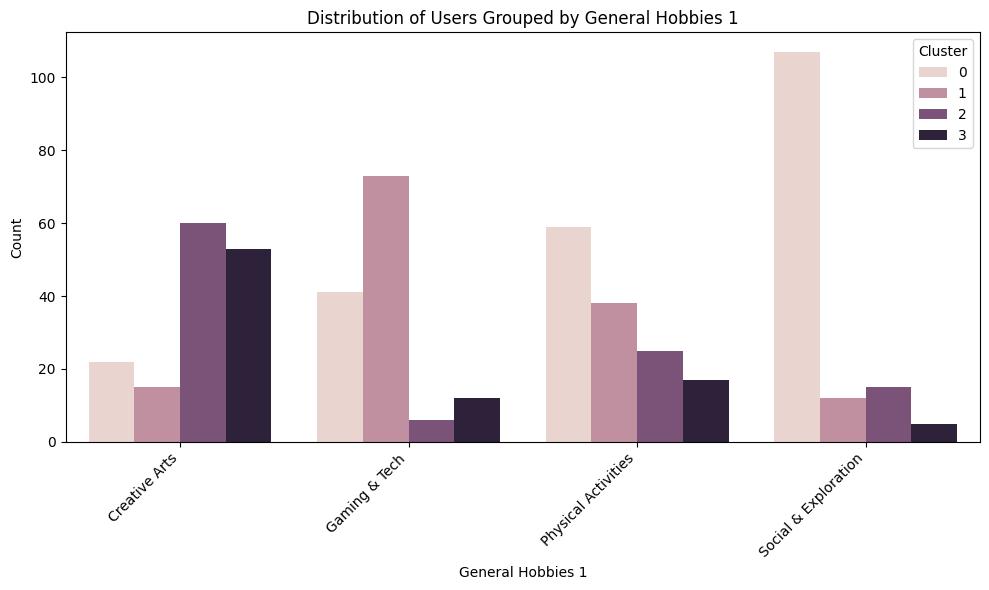

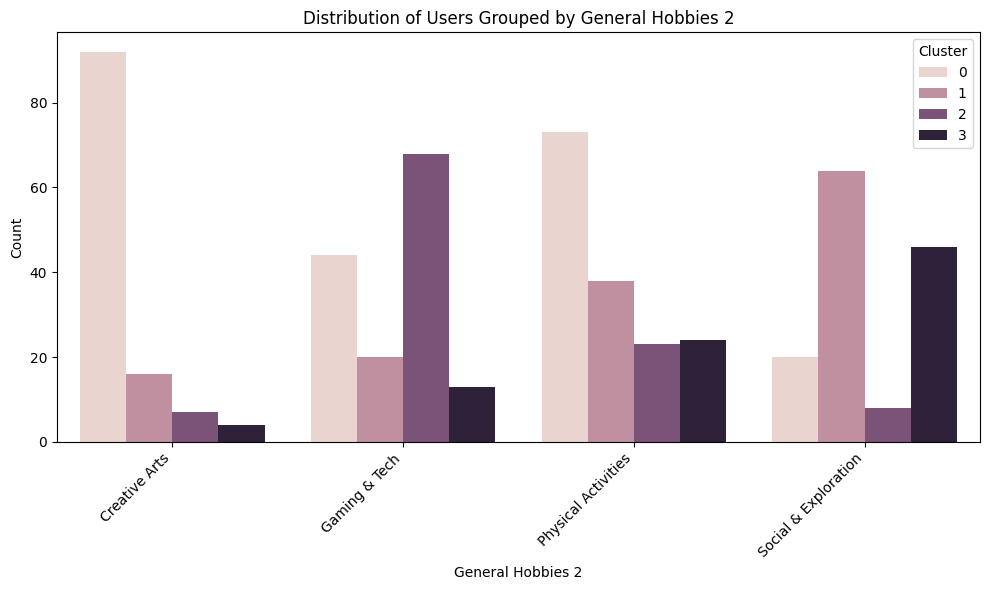

In [ ]:
# Visualise distribution of users across KModes clusters, grouped by features.
for col in final_df.columns[1:-1]:
  df = final_df.copy()
  dist = df.groupby(['clusters', col]).size().reset_index(name='Count')

  # Set up the plot using seaborn
  plt.figure(figsize=(10, 6))
  sns.barplot(x=col, y='Count', hue='clusters', data=dist)

  # Customize plot
  plt.title(f'Distribution of Users Grouped by {col}')
  plt.xlabel(f'{col}')
  plt.ylabel('Count')
  plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
  plt.legend(title='Cluster', loc='upper right')
  plt.tight_layout()

  # Show the plot
  plt.show()

Examining the charts, it is clear that **cluster 0 is the largest cluster**. As with the K-Means algorithm, the main limitation of this method is the inability to specify minimum and maximum cluster sizes.

# HDBSCAN for Density-Based Agglomerative Clustering

In [ ]:
from sklearn.preprocessing import LabelEncoder
new_df = final_df.iloc[:,:-1]

#Perform label encoding for all categorical variables.
le = LabelEncoder()
features_df = pd.DataFrame()

for col in new_df:
    if col != "User_ID" and col != "Specialization":
        features_df[col] = le.fit_transform(new_df[col])

In [ ]:
# Jaccard distance used to compare categorical values.
clusterer = hdbscan.HDBSCAN(min_cluster_size =15, max_cluster_size=45, metric = "jaccard")
clusterer.fit(features_df)
new_df["clusters"] = clusterer.labels_
print(clusterer.labels_.max())

6


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


A total of 7 clusters were found. Users that cannot be grouped into any cluster are labelled -1.

In [ ]:
len(new_df[new_df["clusters"] == -1]) / len(new_df)

0.675

67.5% of users could not be grouped. This can be directly reduced by widening the range of cluster sizes. However, it may be more appropriate to remove already grouped users and perform another round of clustering on the users remaining.

In [ ]:
from random import randint

new_df[new_df["clusters"] == randint(0,clusterer.labels_.max())]

,User_ID,Specialization,Preference 1,Preference 2,Preference 3,Years of experience,Overall coding competency,General Hobbies 1,General Hobbies 2,clusters
4,DAT_005,Data,Python,Java Script,C#,0 to 3 years,Good,Social & Exploration,Physical Activities,2
12,DAT_013,Data,Python,VBA,Java Script,0 to 3 years,Good,Physical Activities,Gaming & Tech,2
27,DAT_028,Data,R,C++,Ruby,0 to 3 years,Good,Gaming & Tech,Social & Exploration,2
85,BAC_006,Backend Engineer,Python,VB .net,Rust,0 to 3 years,Good,Gaming & Tech,Social & Exploration,2
103,BAC_024,Backend Engineer,Python,C#,golang,0 to 3 years,Good,Gaming & Tech,Physical Activities,2
110,BAC_031,Backend Engineer,Java,Java Script,Rust,0 to 3 years,Good,Physical Activities,Social & Exploration,2
118,BAC_039,Backend Engineer,Java,Rust,VBA,0 to 3 years,Good,Physical Activities,Gaming & Tech,2
135,BAC_056,Backend Engineer,Python,R,Ruby,0 to 3 years,Good,Physical Activities,Gaming & Tech,2
141,BAC_062,Backend Engineer,Java,VB .net,golang,0 to 3 years,Good,Social & Exploration,Physical Activities,2
150,BAC_071,Backend Engineer,C#,VB .net,golang,0 to 3 years,Good,Physical Activities,Social & Exploration,2


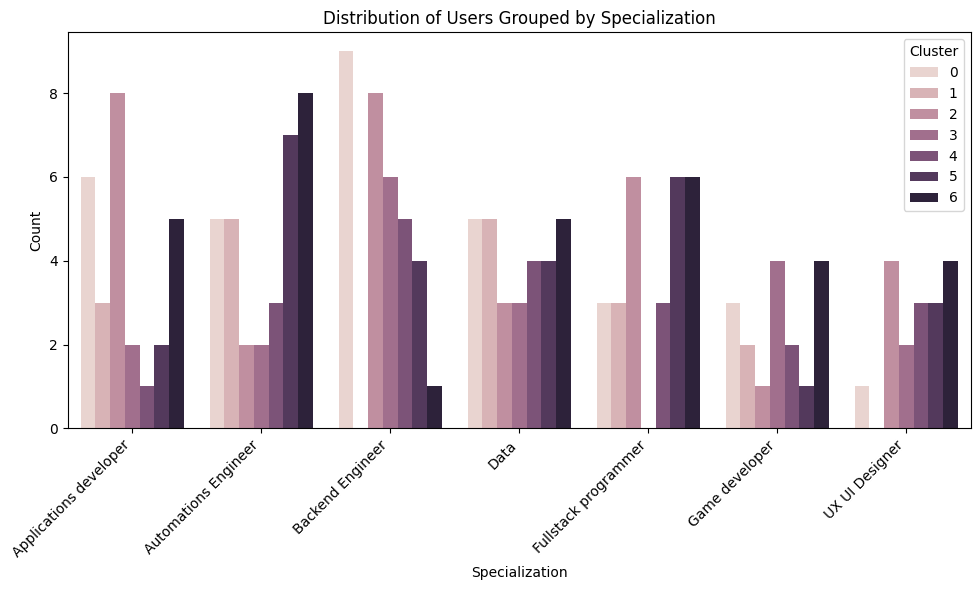

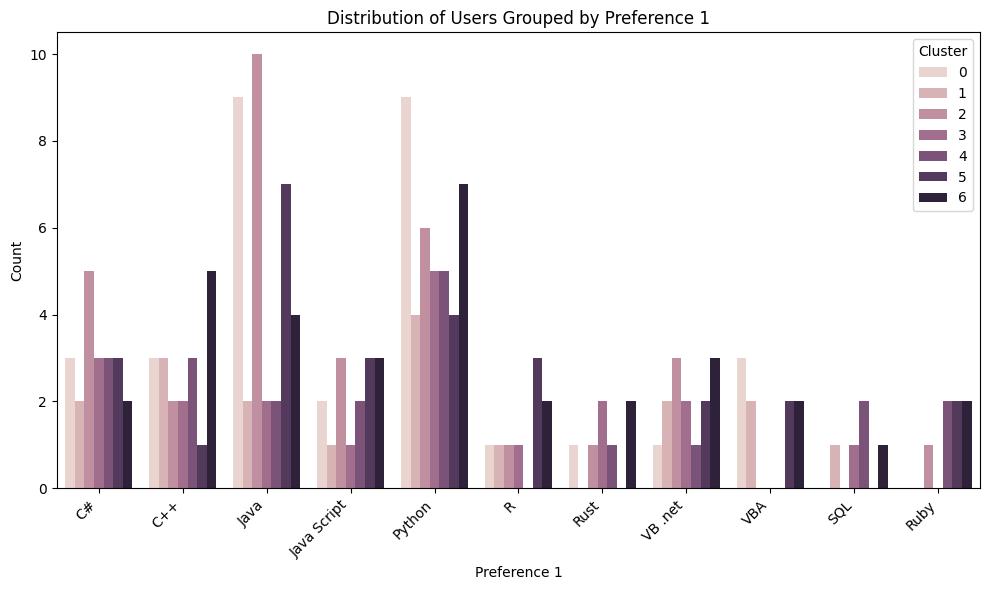

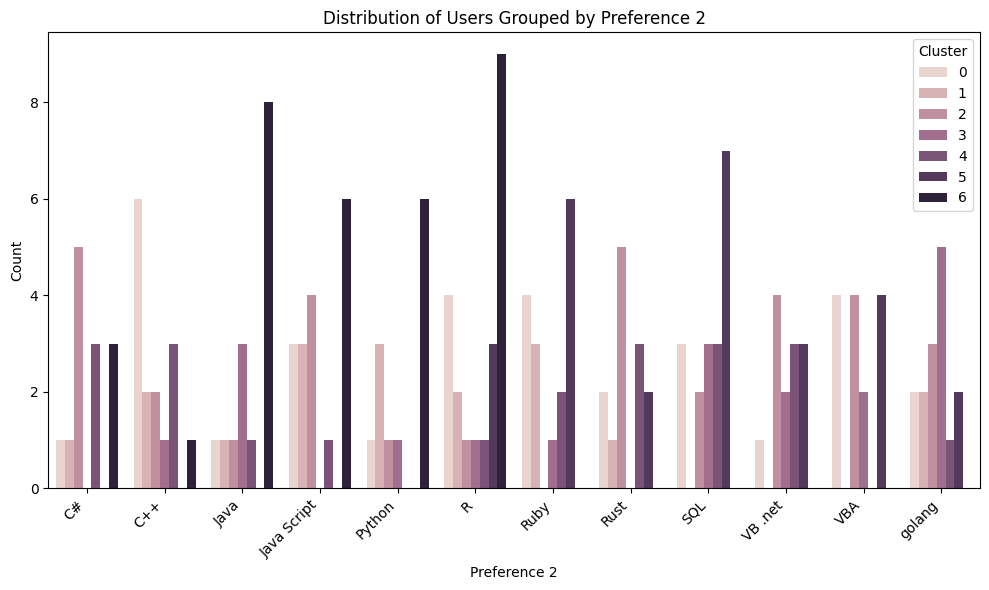

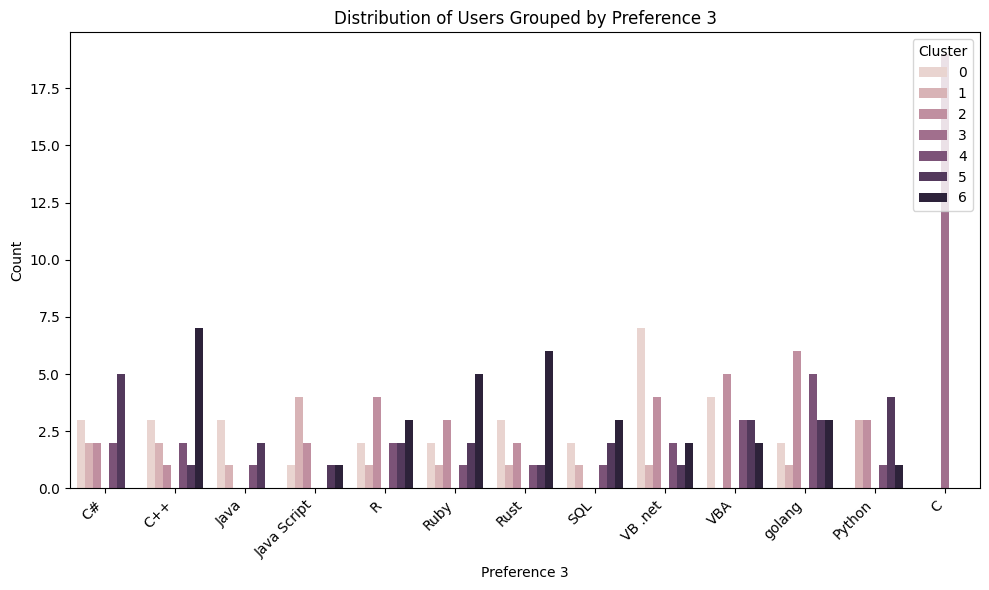

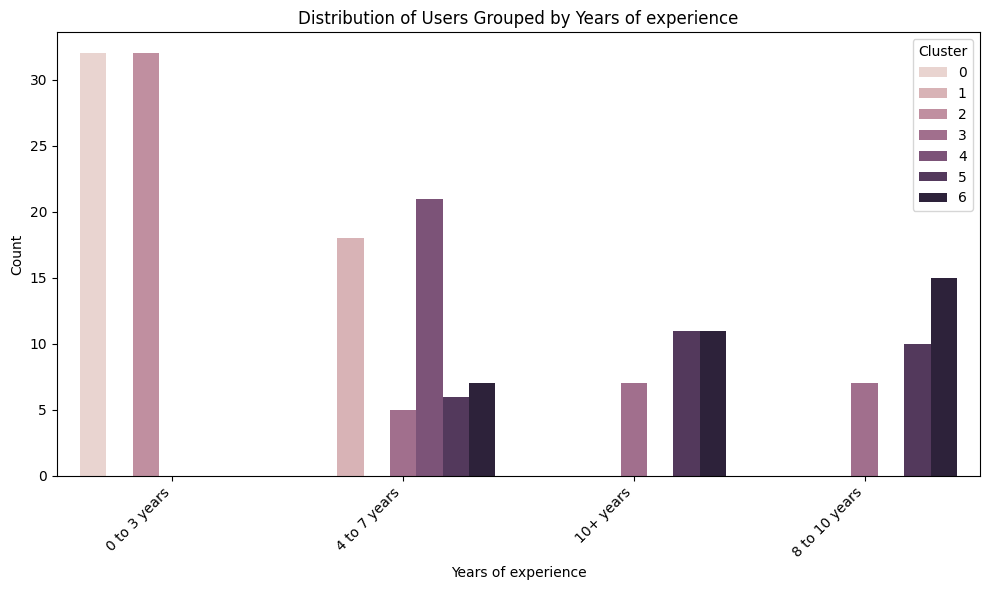

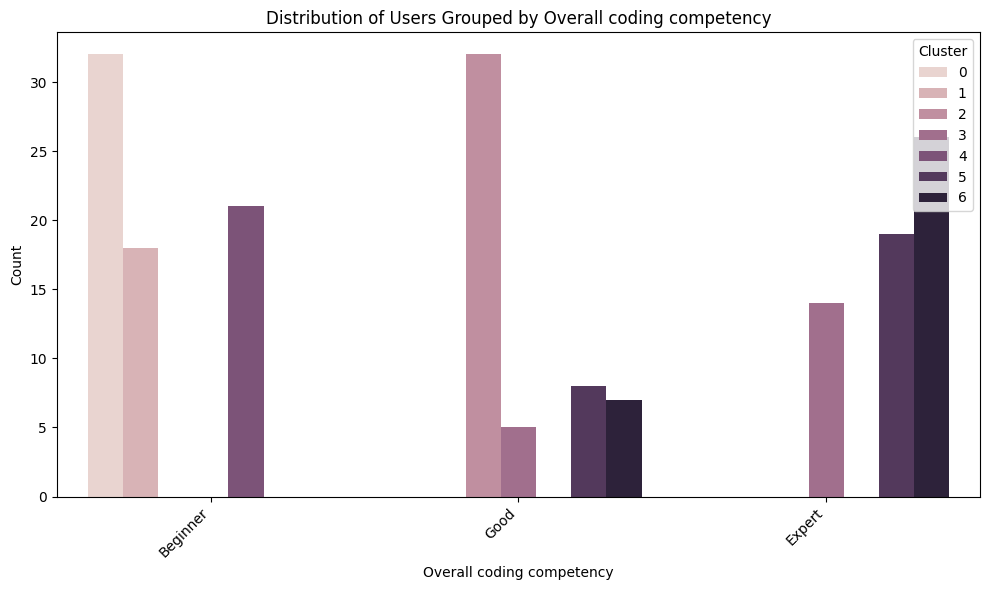

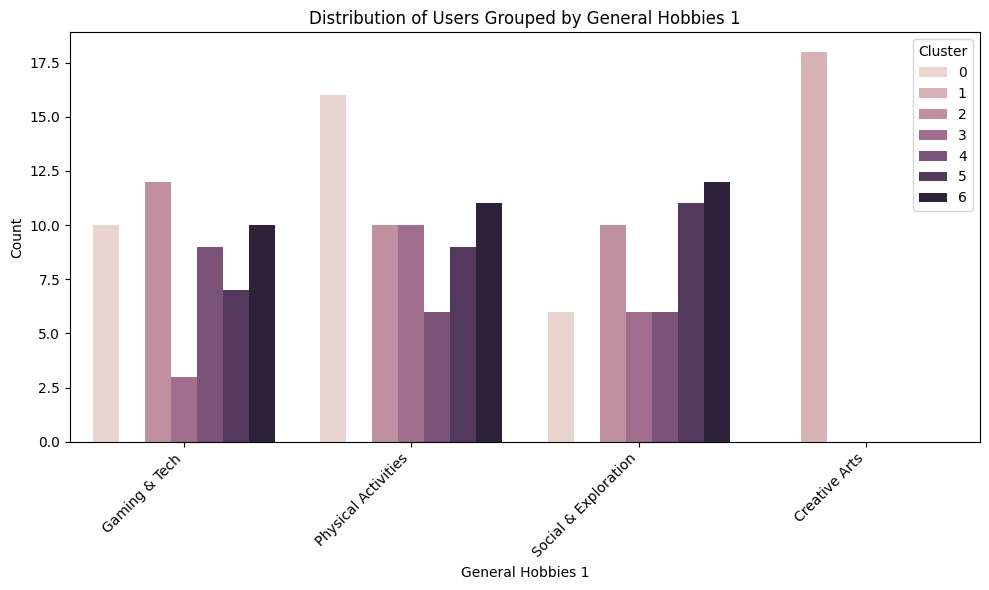

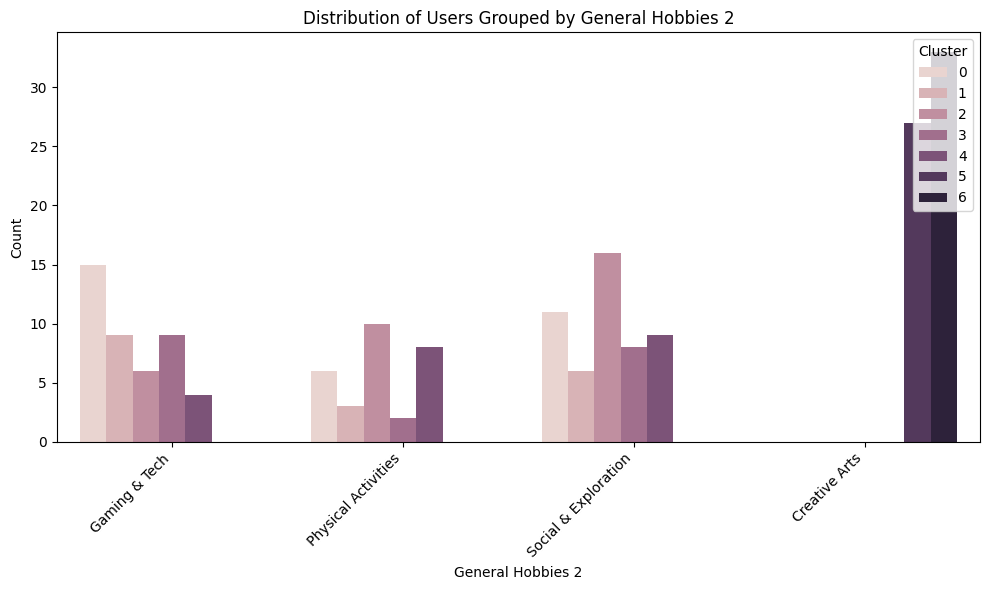

In [ ]:
# Visualise distribution of users across HDBSCAN clusters, grouped by features.
for col in new_df.columns[1:-1]:
  df = new_df[new_df["clusters"] != -1].copy()
  dist = df.groupby(['clusters', col]).size().reset_index(name='Count')

  # Set up the plot using seaborn
  plt.figure(figsize=(10, 6))
  sns.barplot(x=col, y='Count', hue='clusters', data=dist)

  # Customize plot
  plt.title(f'Distribution of Users Grouped by {col}')
  plt.xlabel(f'{col}')
  plt.ylabel('Count')
  plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability
  plt.legend(title='Cluster', loc='upper right')
  plt.tight_layout()

  # Show the plot
  plt.show()